# 3.6 手描き文字の認識

## 3.6.3 バッチ処理

In [2]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
import numpy as np
# 機械学習
import torch
# 自動微分
from torch.autograd import Variable
# ニューラルネットワーク
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# ユーティリティ
from torch.utils.data import DataLoader , TensorDataset , Dataset
# 最適化関数
import torch.optim as optim

In [3]:
# データの読み込み
def get_data():
    (x_train, t_train) , (x_test , t_test) = load_mnist(flatten=True , normalize=True, one_hot_label=False)

    # pytorch で読み込める形式に変換する
    x_test_torch = torch.from_numpy(x_test).float()
    t_test_torch = torch.from_numpy(t_test).long()
    return x_test_torch , t_test ,t_test_torch

In [4]:
x , t  ,t_tensor= get_data()
t_tensor.shape

<ipython-input-3-bbb77ddbb357>:7: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  t_test_torch = torch.from_numpy(t_test).long()


torch.Size([10000])

## 学習なしで、いきなり予測する。

In [5]:
# ニューラルネットワークの定義
input_cnt = x.shape[1]
node1 = 50
node2 = 100
node3 = 10

class Net1(nn.Module):
    def __init__(self):
        super(Net1 , self).__init__()
        
        self.fc1 = nn.Linear(input_cnt , node1)
        self.fc2 = nn.Linear(node1 , node2)
        self.fc3 = nn.Linear(node2 , node3)
    
    def forward(self , x):
        
        a1 = F.sigmoid(self.fc1(x))
        a2 = F.sigmoid(self.fc2(a1))
        a3 = F.sigmoid(self.fc3(a2))
        return F.softmax(a3)   

In [6]:
# ニューラルネットワーク
model1 = Net1()

### いきなり予測する

In [8]:
batch_size = 100
accuracy_cnt = 0

dataloader = DataLoader(dataset=x , batch_size=batch_size , shuffle=False)
index = 0

#for i in range(0 , len(x) , batch_size):
#     x_batch = x[i : i+batch_size]
for x_batch in dataloader:
    index += 1
    y_batch = model1(x_batch)
    p = np.argmax(Variable(y_batch).numpy(), axis=1)
    accuracy_cnt += np.sum(p == t[index : index+batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)) )

Accuracy:0.0872


<ipython-input-5-b936f3b20b4d>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(a3)


<b> ↑ 全然精度が悪い。</b>

## 学習あり

In [9]:
# ニューラルネットワークの定義
input_cnt = x.shape[1]
node1 = 50
node2 = 100
node3 = 10

class Net2(nn.Module):
    def __init__(self):
        super(Net2 , self).__init__()
        
        self.fc1 = nn.Linear(input_cnt , node1)
        self.fc2 = nn.Linear(node1 , node2)
        self.fc3 = nn.Linear(node2 , node3)
    
    def forward(self , x):
        
        a1 = F.sigmoid(self.fc1(x))
        a2 = F.sigmoid(self.fc2(a1))
        a3 = F.sigmoid(self.fc3(a2))
        return a3

### 学習のための準備

In [10]:
model2= Net2()

# 損失の定義 (交差エントロピー誤差)　　　←４．２．２で出てくる
criterion = nn.CrossEntropyLoss()

# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）　　　　←6.1.6で出てくる
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model2.parameters() , lr=0.01)

In [12]:
# バッチサイズ　     ←４．２．3で出てくる
batch_size = 100

accuracy_cnt = 0

# 学習回数
epochs = 120

# x と y の値をひとつの変数に格納する
train = TensorDataset(x ,t_tensor)
train_loader = DataLoader(dataset=train , batch_size=batch_size , shuffle=False)

# 誤差の退避領域
loss_list = []
loss_temp = 0

### 学習する

In [13]:
# ログ出力する際の間隔
logdisp = 5

accuracy_list = []
correct_counter = 0
acccnt=len(x)*logdisp

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for X_train , Y_train in train_loader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(X_train) ,Variable(Y_train)
        # 出力を計算する                     ←3.6.2で出てくる
        output = model2(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train.data)
        
        # 損失
        y_pred = torch.max(output.data, axis=1)[1]
        correct_temp = (y_train == y_pred).sum()
        correct_counter += correct_temp
        
        # パラメータの勾配を初期化する       ←6.2.1で出てくる
        optimizer.zero_grad()
        # ロスを伝播する        ←５章で出てくる
        loss.backward()
        # パラメータを更新する       ←５章で出てくる
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 一定回数毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp=total_loss/acccnt
        print(f'Epoch\t{epoch+1}\t\tLoss\t{loss_tmp:.8f}\t\taccuracy:\t{(correct_counter*100)/acccnt:.3f}%')
        
        accuracy_list.append(correct_counter.item()*100/(acccnt))
        loss_list.append(loss_tmp)
        loss_temp=0
        total_loss=0
        correct_counter = 0

Epoch	5		Loss	0.00303570		accuracy:	82.162%
Epoch	10		Loss	0.00297268		accuracy:	96.604%
Epoch	15		Loss	0.00295760		accuracy:	98.000%
Epoch	20		Loss	0.00295003		accuracy:	98.612%
Epoch	25		Loss	0.00294379		accuracy:	98.814%
Epoch	30		Loss	0.00294325		accuracy:	98.956%
Epoch	35		Loss	0.00294357		accuracy:	99.100%
Epoch	40		Loss	0.00294058		accuracy:	98.966%
Epoch	45		Loss	0.00293830		accuracy:	99.018%
Epoch	50		Loss	0.00293428		accuracy:	99.346%
Epoch	55		Loss	0.00294705		accuracy:	98.992%
Epoch	60		Loss	0.00293802		accuracy:	98.928%
Epoch	65		Loss	0.00293515		accuracy:	99.244%
Epoch	70		Loss	0.00293417		accuracy:	99.294%
Epoch	75		Loss	0.00293132		accuracy:	99.510%
Epoch	80		Loss	0.00293111		accuracy:	99.552%
Epoch	85		Loss	0.00294575		accuracy:	98.688%
Epoch	90		Loss	0.00293589		accuracy:	99.126%
Epoch	95		Loss	0.00293366		accuracy:	99.462%
Epoch	100		Loss	0.00293021		accuracy:	99.486%
Epoch	105		Loss	0.00293189		accuracy:	99.338%
Epoch	110		Loss	0.00293379		accuracy:	99.336%
Epoch	11

### 予測する

In [14]:
y = model2(x)
p = np.argmax(Variable(y).numpy(), axis=1)
accuracy_cnt += np.sum(p == t)

print("Accuracy:" + str(float(accuracy_cnt) / len(x)) )

Accuracy:0.9959


### 学習時の誤差が下がっていく事と、精度向上の可視化

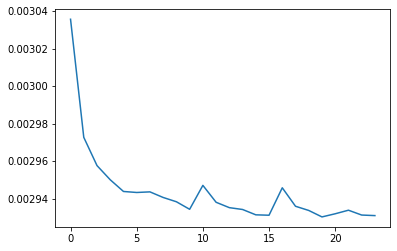

In [15]:
import matplotlib.pyplot as plt
# 誤差の推移
plt.plot(loss_list)

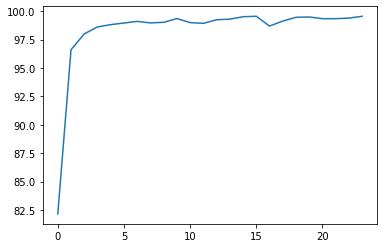

In [16]:
# 正解率の推移
plt.plot(accuracy_list)

# 本の結果（比較用）

In [8]:
batch_size = 100
accuracy_cnt = 0
for i in range(0 , len(x) , batch_size):
    x_batch = x[i : i+batch_size]
    y_batch = predict(network , x_batch)
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i : i+batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)) )

Accuracy:0.9352
